Контест:
https://www.kaggle.com/competitions/classification-of-butterflies

In [44]:
!pip install opendatasets

In [45]:
import re
import pandas as pd
import os
import cv2
import numpy as np
import opendatasets as od

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Input, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam, Adamax


import matplotlib.pyplot as plt
from tensorflow.keras.applications.resnet50 import ResNet50
from google.colab import files
from IPython.display import Image

In [46]:
od.download("https://www.kaggle.com/competitions/classification-of-butterflies/overview")

Skipping, found downloaded files in "./classification-of-butterflies" (use force=True to force download)


## Считывание данных

In [47]:
img_shape = (224,224,3)
train_dir = os.path.join('/content/classification-of-butterflies/train_butterflies/train_split')
img_size = (img_shape[0], img_shape[1])
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size = img_size,
    seed = 123,
    batch_size = 15)

Found 4955 files belonging to 50 classes.


In [48]:
valid_dir = os.path.join('/content/classification-of-butterflies/test_butterflies')
img_size = (img_shape[0], img_shape[1])
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    valid_dir,
    image_size=img_size,
    seed=123,
    batch_size=15)

Found 250 files belonging to 1 classes.


In [49]:
test_dir = os.path.join('/content/classification-of-butterflies/test_butterflies')
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = None,
    image_size = img_size,
    batch_size = 15)

Found 250 files belonging to 1 classes.


In [50]:
class_names = train_ds.class_names
class_count = 50

In [51]:
class_names

['class_0',
 'class_1',
 'class_10',
 'class_11',
 'class_12',
 'class_13',
 'class_14',
 'class_15',
 'class_16',
 'class_17',
 'class_18',
 'class_19',
 'class_2',
 'class_20',
 'class_21',
 'class_22',
 'class_23',
 'class_24',
 'class_25',
 'class_26',
 'class_27',
 'class_28',
 'class_29',
 'class_3',
 'class_30',
 'class_31',
 'class_32',
 'class_33',
 'class_34',
 'class_35',
 'class_36',
 'class_37',
 'class_38',
 'class_39',
 'class_4',
 'class_40',
 'class_41',
 'class_42',
 'class_43',
 'class_44',
 'class_45',
 'class_46',
 'class_47',
 'class_48',
 'class_49',
 'class_5',
 'class_6',
 'class_7',
 'class_8',
 'class_9']

## Построение модели

In [52]:
%%time
input = Input(shape = img_shape)
x = tf.keras.applications.EfficientNetB3(include_top=False, weights="imagenet", pooling='max')(input)
x = Dropout(rate=.2, seed=123)(x)
output = Dense(class_count, activation='softmax')(x)
model = Model(inputs = input, outputs = output)
model.compile(
    optimizer = Adamax(lr=.01),
    loss = tf.losses.SparseCategoricalCrossentropy(),
    metrics = ['accuracy'])

history = model.fit(train_ds, validation_data = valid_ds, epochs = 10, verbose = 1)

Epoch 1/10
331/331 [==============================] - 143s 261ms/step - loss: 1.7286 - accuracy: 0.6492 - val_loss: 13.5670 - val_accuracy: 0.0200
Epoch 2/10
331/331 [==============================] - 86s 260ms/step - loss: 0.2502 - accuracy: 0.9288 - val_loss: 16.1970 - val_accuracy: 0.0200
Epoch 3/10
331/331 [==============================] - 85s 258ms/step - loss: 0.1359 - accuracy: 0.9572 - val_loss: 17.3190 - val_accuracy: 0.0200
Epoch 4/10
331/331 [==============================] - 86s 259ms/step - loss: 0.1003 - accuracy: 0.9709 - val_loss: 19.0060 - val_accuracy: 0.0200
Epoch 5/10
331/331 [==============================] - 85s 257ms/step - loss: 0.0776 - accuracy: 0.9772 - val_loss: 20.2247 - val_accuracy: 0.0200
Epoch 6/10
331/331 [==============================] - 86s 259ms/step - loss: 0.0661 - accuracy: 0.9800 - val_loss: 22.2018 - val_accuracy: 0.0200
Epoch 7/10
331/331 [==============================] - 86s 258ms/step - loss: 0.0520 - accuracy: 0.9859 - val_loss: 20.2533 

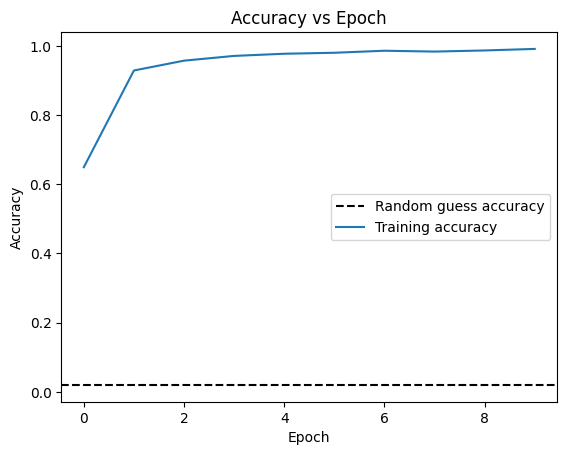

In [53]:
random_guess_accuracy = 1/50
train_accuracy = history.history['accuracy']
plt.axhline(y=random_guess_accuracy, color='black', linestyle='dashed', label='Random guess accuracy')
plt.plot(train_accuracy, label='Training accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

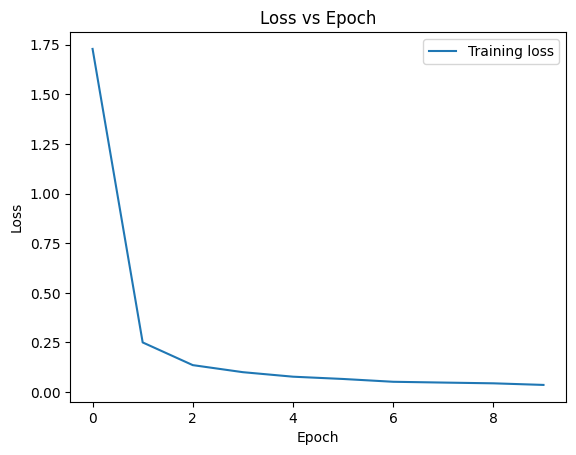

In [54]:
train_accuracy = history.history['loss']
plt.plot(train_accuracy, label='Training loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [55]:
test_path = '/content/classification-of-butterflies/test_butterflies/valid'
test = {'img': [], 'index': []}
for file in os.listdir(test_path):
    img = cv2.imread(f'{test_path}/{file}')
    test['img'].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    test['index'].append(int(file.replace('.jpg', '')))
test = {'img': np.array(test['img']),'index': np.array(test['index'])}
preds = model.predict(test['img'], verbose=1)

ypred = []
for i, p in enumerate(preds):
    index = np.argmax(p)
    klass = class_names[index]
    ypred.append(klass)
ypred = np.array(ypred)

df = pd.DataFrame(ypred, columns=['label'])
df['label'] = df['label'].str.replace("class_",'')
df['label'] = df['label'].astype(int)
df = df.reset_index()
df['index'] = test['index']

8/8 [==============================] - 6s 123ms/step


In [56]:
df.to_csv('predictions.csv', index=False)
files.download('predictions.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

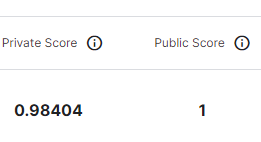

In [57]:
Image(filename='/content/best_EfficientNet.png')


# при более долгом обучении бейзлайн-модели получен следующий результат:
# ***public_score*** = **1**
# ***private_csore*** = **0.98404**

# **Model based on Resnet50**

In [58]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 50
not_base_model = tf.keras.Sequential([
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
not_base_model.compile(optimizer='adam',
              loss = tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])
for layer in not_base_model.layers:
  layer.trainable = False
# Unfreeze the last 2 layers
for layer in not_base_model.layers[-3:]:
  layer.trainable = True

history = not_base_model.fit(
  train_ds,
  epochs = 10,
  validation_data=valid_ds
)

Epoch 1/10
331/331 [==============================] - 94s 176ms/step - loss: 2.8826 - accuracy: 0.2416 - val_loss: 12.5139 - val_accuracy: 0.0000e+00
Epoch 2/10
331/331 [==============================] - 59s 179ms/step - loss: 1.4679 - accuracy: 0.5661 - val_loss: 12.9764 - val_accuracy: 0.0280
Epoch 3/10
331/331 [==============================] - 59s 177ms/step - loss: 0.9351 - accuracy: 0.7098 - val_loss: 11.1363 - val_accuracy: 0.0160
Epoch 4/10
331/331 [==============================] - 59s 179ms/step - loss: 0.6857 - accuracy: 0.7859 - val_loss: 11.1231 - val_accuracy: 0.0280
Epoch 5/10
331/331 [==============================] - 59s 178ms/step - loss: 0.4970 - accuracy: 0.8436 - val_loss: 13.1118 - val_accuracy: 0.0240
Epoch 6/10
331/331 [==============================] - 59s 177ms/step - loss: 0.4204 - accuracy: 0.8666 - val_loss: 16.4193 - val_accuracy: 0.0120
Epoch 7/10
331/331 [==============================] - 59s 178ms/step - loss: 0.3425 - accuracy: 0.8882 - val_loss: 15.27

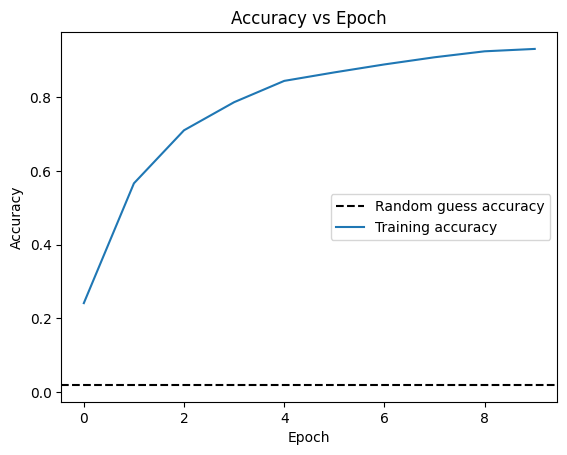

In [59]:
random_guess_accuracy = 1/50
train_accuracy = history.history['accuracy']
plt.axhline(y=random_guess_accuracy, color='black', linestyle='dashed', label='Random guess accuracy')
plt.plot(train_accuracy, label='Training accuracy')
plt.title('Accuracy vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

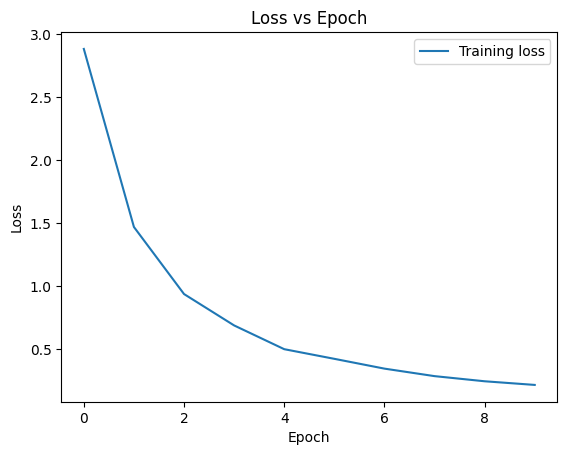

In [60]:
train_accuracy = history.history['loss']
plt.plot(train_accuracy, label='Training loss')
plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [61]:
test_path = '/content/classification-of-butterflies/test_butterflies/valid'
test2 = {'img': [],'index': []}

for file in os.listdir(test_path):
    img = cv2.imread(f'{test_path}/{file}')
    test2['img'].append(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    test2['index'].append(int(file.replace('.jpg', '')))
test2 = {'img': np.array(test2['img']),'index': np.array(test2['index'])}
preds2 = not_base_model.predict(test2['img'], verbose=1)

ypred2 = []
for i, p in enumerate(preds2):
    index = np.argmax(p)
    klass = class_names[index]
    ypred2.append(klass)
ypred2 = np.array(ypred2)

df2 = pd.DataFrame(ypred2, columns=['label'])
df2['label'] = df2['label'].str.replace("class_",'')
df2['label'] = df2['label'].astype(int)
df2 = df2.reset_index()
df2['index'] = test['index']

8/8 [==============================] - 3s 97ms/step


In [62]:
df2.to_csv('predictions2.csv', index=False)
files.download('predictions2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

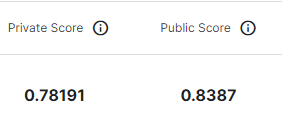

In [63]:
Image(filename='/content/resnet_model.png')


# При обучении модели основанной на resnet50 получен следующий результат:
# ***public_score*** = **0.8387**
# ***private_csore*** = **0.78191**